# Gradient Descent for Polynomial Regression
There's some fake data in the file "data.csv", with a single feature (x) and a true value (y). Your task is to:
1. Load the data and look at it
2. Split it into training, validation, and test sets
3. Create your design matrix
4. Implement gradient descent to find the best fit polynomial
5. Evaluate your model's performance and experiment with different hyperparameters

It's up to you to decide what degree polynomial to fit the data, and you can also play around with stochastic gradient descent, mini-batch, hyperparameters, etc.

Try to do this without the use of scikit learn or other libraries aside from `numpy` and `matplotlib`.

## Step 0: Import libraries and seed your random number generator
It's usually a good idea to start with a consistent random number seed to ensure reproducibility.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#TODO: random number seed
np.random.seed(123)

## Step 1: Load the data and look at it

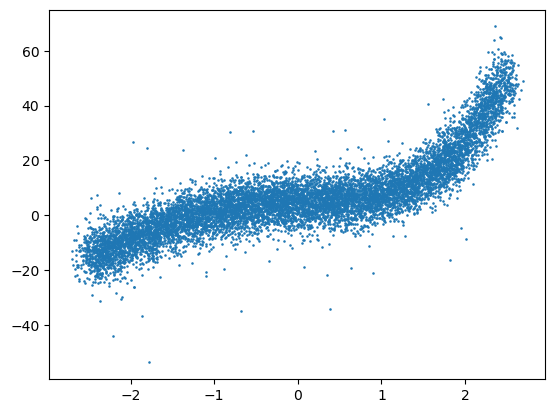

In [2]:
x, y = np.loadtxt("data.csv", delimiter=",", skiprows=1, unpack=True)
#TODO: visualize
plt.scatter(x,y, s=0.7)

## Step 2: Split the data
If you're selecting random samples, I'd recommend a random seed to have consistent results and avoid data leakage when you re-run the notebook.

Weird numpy quirk: by default, a 1D array has a shape of `(n,)`, but to behave as a proper vector, we need to convert it to be `(n, 1)`. An easy way to do this is to pass `np.newaxis` as the second index when sampling your `y` data, e.g.:

```python
y_train = y[<selected range>, np.newaxis]
```

Don't worry about the x values for now, as we'll be matrixifying them shortly anyway.

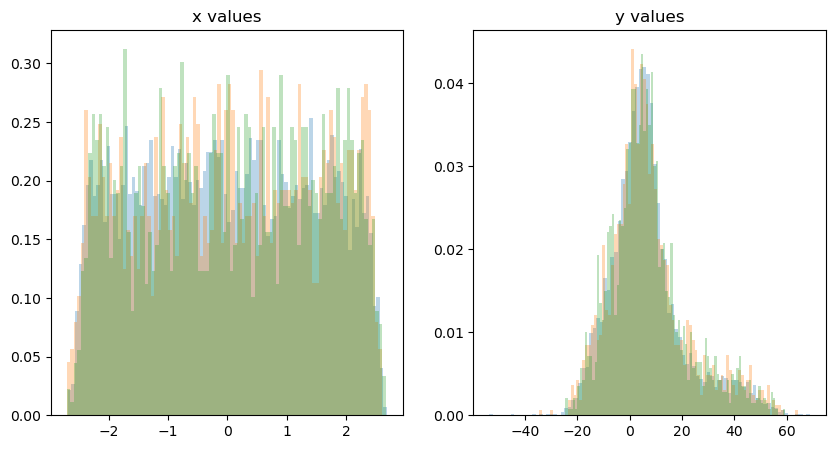

In [3]:
# we didnt have any library supports train_test_split
# so we have to make our own train_test_split

train_size = int(len(x) * 0.7)
val_size = int(len(x) * 0.15)
test_size = len(x) - train_size - val_size

x_train, y_train = x[:train_size], y[:train_size, np.newaxis]
x_val, y_val = x[train_size:train_size+val_size], y[train_size:train_size+val_size, np.newaxis]
x_test, y_test = x[train_size+val_size:], y[train_size+val_size:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].hist(x_train, bins=90, alpha=0.3, label="train", density=True)
axes[0].hist(x_val, bins=90, alpha=0.3, label="val", density=True)
axes[0].hist(x_test, bins=90, alpha=0.3, label="test", density=True)
axes[0].set_title("x values")
axes[1].hist(y_train, bins=90, alpha=0.3, label="train", density=True)
axes[1].hist(y_val, bins=90, alpha=0.3, label="val", density=True)
axes[1].hist(y_test, bins=90, alpha=0.3, label="test", density=True)
axes[1].set_title("y values")
plt.show()

## Step 3: Create your **design matrix** $X$.

For the example given in class, the design matrix was simply a column of 1s concatenated with the feature vector, i.e.:

$$X = \begin{bmatrix} 1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_m \end{bmatrix}$$

For this exercise, you probably want to fit a higher degree polynomial, so the design matrix will be something like:

$$X = \begin{bmatrix} 1 & x_1 & x_1^2 & \ldots & x_1^d \\ 1 & x_2 & x_2^2 & \ldots & x_2^d \\ \vdots & \vdots & \vdots & \vdots & \vdots \\ 1 & x_m & x_m^2 & \ldots & x_m^d \end{bmatrix}$$

where $d$ is the degree of the polynomial you want to fit. Try multiple degrees and see what gives the best results.

> A note on scaling: the range of x values in this example is fairly small, but if you choose a high degree polynomial you will still end up with fairly different scales for your "features". Consider normalizing each column of the design matrix (other than the first column accounting for the bias term), remembering to calculate your scaling parameters on the training data and apply them to the validation/test data.

Since you've got three x vectors (train/test/val), you might want to define a function to create the design matrix given a vector x and a degree d.

In [11]:
def matrix(d, x):
    return np.column_stack([x**i for i in range(d+1)])

d = 4
X_train = matrix(d, x_train)

mu = np.array([0] + [X_train[:, i].mean() for i in range(1, d+1)])
print(mu[0])
sigma = np.array([1] + [X_train[:, i].std() for i in range(1, d+1)])
print(sigma[1])

X_train = (X_train - mu) / sigma
print(X_train)
X_val = matrix(d, x_val)
X_val = (X_val - mu) / sigma
print(X_val)

0.0
1.442042524613524
[[ 1.         -1.42779148  1.18465689 -1.48116642  0.99060263]
 [ 1.         -0.01515404 -1.09495178  0.014179   -0.72679097]
 [ 1.          0.36414399 -0.96231264  0.03540192 -0.72089499]
 ...
 [ 1.         -1.07880327  0.21476127 -0.63732905 -0.15953273]
 [ 1.         -0.64795985 -0.61448471 -0.13085469 -0.65025128]
 [ 1.          1.18604779  0.40685724  0.81407035  0.01892592]]
[[ 1.          0.53644963 -0.79791793  0.08483249 -0.6974637 ]
 [ 1.         -1.43871359  1.2193184  -1.51538627  1.04320269]
 [ 1.          0.52564647 -0.8101368   0.08053302 -0.69981924]
 ...
 [ 1.         -1.28203291  0.74711256 -1.07218163  0.39483596]
 [ 1.          1.56382289  1.53275492  1.86466595  1.55488014]
 [ 1.         -0.63406998 -0.63445016 -0.1219265  -0.65646769]]


## Step 4: Implement gradient descent
This has a number of sub components. First you'll need to define your gradient function. For mean squared error, the gradient can be calculated as:

$$\nabla_{\theta} MSE = \frac{2}{m}X^T(X\mathbf{\theta} - \mathbf{y})$$

where $X$ is your design matrix, $\mathbf{\theta}$ is the current parameter vector, and $\mathbf{y}$ is the true target value.

It'll also be useful to define the actual mean squared error to evaluate your model:

$$MSE = \frac{1}{m}(\mathbf{X} \mathbf{\theta} - \mathbf{y})^T (\mathbf{X} \mathbf{\theta} - \mathbf{y})$$

In [31]:
# (m,n) row column

def gradient(X, y, theta):
    return ((2 / X.shape[0]) * X.T) @ (X @ theta - y)

def mse(X, y, theta):
    return (1 / X.shape[0]) * ((X @ theta - y).T @ (X @ theta - y))

Now you can define your hyperparameters and run your gradient descent. For minibatch gradient descent, you'll need to define:
- learning rate $\eta$ (usually in the range of $10^{-5}$ to $10^{-2}$)
- number of epochs
- batch size

Recall that an **epoch** is a full pass through your training data - or rather, sampling your training data $m_{\mathrm{train}}$ times, as you are not guaranteed to select every sample in every epoch. This means that for every epoch, you'll need to select $\frac{m_{\mathrm{train}}}{b}$ batches, where $b$ is your batch size.

The general algorithm for gradient descent is:
1. Start with a random $\mathbf{\theta}$
2. Pick a random batch of instances $\mathbf{x}_i$ (rows in your design matrix)
3. Calculate the gradient $\nabla_{\mathbf{\theta}}$ for the current $\mathbf{\theta}$ and $\mathbf{x}_i$
4. Update $\mathbf{\theta}$ as $\mathbf{\theta} = \mathbf{\theta} - \eta \nabla_{\mathbf{\theta}}$
5. Repeat 2-4 until some stopping criterion is met

Stochastic gradient descent is when your batch size is 1, while standard gradient descent is a batch size of $m_{\mathrm{train}}$.

In [34]:
# learn_rate = 0.001
# n_epochs = 150
# batch_size = 32
# batches_per_epoch = train_size // batch_size
# theta = np.random.randn(d+1, 1)

# mse_train = np.zeros((n_epochs, 1))
# mse_val = np.zeros((n_epochs, 1))

# for epoch in range(n_epochs):
#     for _ in range(batches_per_epoch):
#         random_batch = np.random.choice(np.arange(train_size), batch_size)
#         X_batch = X_train[random_batch,:]
#         y_batch = y_train[random_batch,:]
#         curr_grad = gradient(X_batch, y_batch, theta)
#         theta -= (learn_rate*curr_grad)
    
#     mse_train[epoch] = mse(X_batch, y_batch, theta)
#     mse_val[epoch] = mse(X_batch, y_batch, theta) 

eta = 1e-3
n_epochs = 100
batch_size = 16
batches_per_epoch = train_size // batch_size
theta = np.random.randn(d+1, 1)

# Extra: keep track of mse for both train and val sets to plot
mse_train = np.zeros((n_epochs, 1))
mse_val = np.zeros((n_epochs, 1))

for epoch in range(n_epochs):
    for _ in range(batches_per_epoch):
        rand_ids = np.random.choice(np.arange(train_size), batch_size)
        X_batch = X_train[rand_ids,:]
        y_batch = y_train[rand_ids,:]
        current_grad = gradient(X_batch, y_batch, theta)
        theta -= eta * current_grad
    
    mse_train[epoch] = mse(X_train, y_train, theta)
    mse_val[epoch] = mse(X_val, y_val, theta)



## Step 5: Evaluate your model's performance and experiment
Now that you've computed a $\mathbf{\theta}$, apply it to your validation set to see how well your model performs, perhaps by plotting the data as well as the best fit curve. You could also declare an array of mse values to update at each epoch to plot and compare the performance of train and validation sets.

Try changing various hyperparameters, like $\eta$, batch size, number of epochs, etc. You can also experiment with the degree of the polynomial, keeping in mind that dropping higher order terms is a form of regularization. If you didn't rescale your design matrix earlier, try it now! Once you're happy with the final model, see how it behaves on your held out test set.